### Непараметрические критерии (Двухвыборочный для связанных выборок)

### Терапия при анорексии 
В исследовании оценивается эффективность поведенческой терапии для лечения анорексии. Для 50 пациентов известен вес до начала терапии и по её окончании. Была ли терапия эффективной?

In [2]:
import pandas as pd
import numpy as np 
import itertools
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

In [8]:
data = pd.read_csv('weight.txt', sep = '\t')
data.head()

,Before,After
0,80.5,82.2
1,84.9,85.6
2,81.5,81.4
3,82.6,81.9
4,79.9,76.4


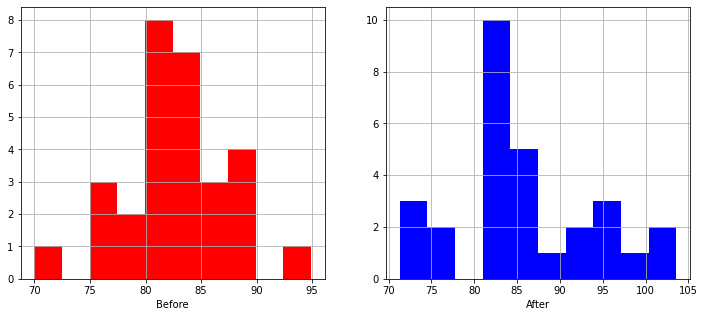

In [13]:
# Взглянем на распределения признаков 
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist(data['Before'], color = 'r')
plt.xlabel('Before')
plt.grid()

plt.subplot(1,2,2)
plt.hist(data['After'], color = 'b')
plt.xlabel('After')
plt.grid()

По гистограммам видно, что ```min``` и ```max``` значения без после терапии отличаются, ровно как и их средние. Но значимы ли эти отличия?

In [17]:
print('Therapy A Mean: ', round(data['Before'].mean(), 4))
print('Therapy B Mean: ', round(data['After'].mean(), 4))

Therapy A Mean:  82.6897
Therapy B Mean:  85.6966


### Интервальная оценка среднего

In [27]:
print('95 %% Confidence Interval (Group Before): [%.4f, %.4f]' % zconfint(data['Before']))
print('95 %% Confidence Interval (Group After): [%.4f, %.4f]' % zconfint(data['After']))

95 Confidence Interval (Group Before): [80.9261, 84.4532]
95 Confidence Interval (Group After): [82.6568, 88.7363]


Интервалы пересекаются, поэтому недостаточно использования ДИ для однозначного принятие или отвержения нулевой гипотезы. Необходимо применять критерии для проверки гипотез.

### Двухвыборочные критерии для связных выборок
Расммотрим гипотезы:

$H_0\colon$ медианы веса до и после терапии совпадает

$H_1\colon$ медианы веса до и после тепрапии отличаются

Для того чтобы применять двухвыборочные критерии для проверки гипотез, для начала нам нужно посчитать попарные разности весов пациентов до и после терапии. Давайте это сделаем и посмотрим на то, как эта величина распределена.

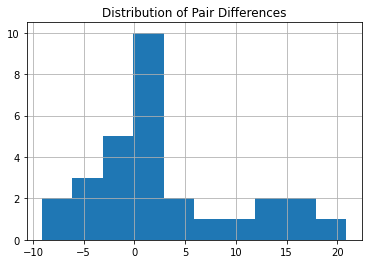

In [30]:
plt.hist(data['After'] - data['Before']);
plt.grid()
plt.title('Distribution of Pair Differences');

Видно, что основное значение колеблется около нуля.

### Двухвыборочный критерий знаков
Используем готовую реализацию критерия ```sign_test()```


In [33]:
print('Statistics: %.2f, p-value: %.4f' %sign_test(data['After'] - data['Before']))

Statistics: 3.50, p-value: 0.2649


Нулевая гипотеза не отвергается

### Критерий знаковых рангов (Критерий знаковых рангов Вилкоксона)
Эту функцию можно применять по-разному. С одной стороны, мы можем передать туда две выборки, с другой стороны, мы точно так же, как и в случае с критерием знаков, можем передать туда попарные разности. Посмотрим на оба подхода

In [34]:
# Без разностей
stats.wilcoxon(data['After'], data['Before'])

WilcoxonResult(statistic=131.5, pvalue=0.06291972262602667)

In [35]:
# Разности 
stats.wilcoxon(data['After'] - data['Before'])

WilcoxonResult(statistic=131.5, pvalue=0.06291972262602667)

Можно приметь любой способ. Нулевая гипотеза также не отвергается

### Перестановачный критерий
В данном случае гипотезы:

$H_0\colon \mathbb{E}(X_1 - X_2) = 0$

$H_1\colon \mathbb{E}(X_1 - X_2) \neq 0$

Готовой реализации нет, реализуем самостоятельно

In [37]:
# Функция расчета t - статистики
def permutation_t_stat_1sample(sample, mean):
    t_stat = sum(sample - mean)
    return t_stat

# Функция для расчета нулевого распределения (распределение должно получиться табличным)
def permutation_zero_distr_1sample(sample, mean, max_permutations = None):
    centered_sample = sample - mean
    
    # Если задан, то генерируем случайные выборки со случайными перестановками знаков перед элементами
    # Т.е. для больших выбарок будет достаточно лишь некоторой части перестановок
    if max_permutations:
        # Генерируем знаки (-1, 1)
        signs_array = set([tuple(x) for x in 2 * np.random.randint(2, size = (max_permutations, len(sample))) - 1])
    else:
        signs_array = itertools.product([-1, 1], repeat = len(sample))
        
    zero_distribution = [sum(centered_sample * sign) for sign in signs_array]
    
    return zero_distribution

def get_p_value_permutation_test_1sample(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError ('Alternative Not Recognized!!!')
        
    t_stat = round(permutation_t_stat_1sample(sample, mean), 4)
    zero_distribution = permutation_zero_distr_1sample(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return t_stat, round(sum([1 if abs(x) >= abs(t_stat) else 0 for x in zero_distribution]) / len(zero_distribution), 4)
    
    if alternative == 'less':
        return t_stat, round(sum([1 if x <= t_stat else 0 for x in zero_distribution]) / len(zero_distribution), 4)

    if alternative == 'greater':
        return t_stat, round(sum([1 if x >= t_stat else 0 for x in zero_distribution]) / len(zero_distribution), 4)

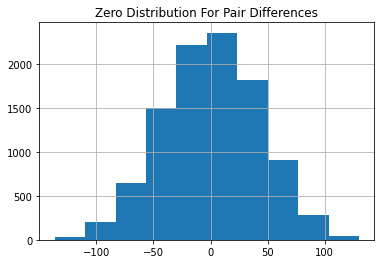

In [41]:
# Взглянем на нулевое распределение попарных разностей 
plt.hist(permutation_zero_distr_1sample(data['After'] - data['Before'], mean = 0, max_permutations = 10000))
plt.grid()
plt.title('Zero Distribution For Pair Differences');

In [42]:
test_res_1 = get_p_value_permutation_test_1sample(data['After'] - data['Before'], mean = 0, max_permutations = 1000)
print(f'Statistics: {test_res_1[0]}, p-value: {test_res_1[1]}')

Statistics: 87.2, p-value: 0.044


In [43]:
# Возьмем больше перестановок
test_res_2 = get_p_value_permutation_test_1sample(data['After'] - data['Before'], mean = 0, max_permutations = 50000)
print(f'Statistics: {test_res_2[0]}, p-value: {test_res_2[1]}')

Statistics: 87.2, p-value: 0.034


Используя данный критерий мы можем отвергнуть нулевую гипотезу и утверждать, что терапия оказала эффект. Почему применяя разные критерии мы вынуждены делать разные выводы?

Ну, во-первых, разные критерии по-разному оценивают среднее. В случае критерия знаков под «средним» мы с вами понимаем «медиану веса», а в случае перестановочного критерия под «средним» мы с вами понимаем «матожидание разности весов». Уже в этом месте начинаются разночтения.

С другой стороны, разница есть в том, как много информации использует критерий. В частности, знаковые критерии используют только знаки перед нашими значениями и не учитывают абсолютные значения. Ранговые критерии используют только порядка. Перестановочный критерий уже использует гораздо больше информации, потому что он учитывает значение. Соответственно, в этом случае нам оказалось этого достаточно для того, чтобы отвергнуть нулевую гипотезу